# Visualize Streamflow
The purpose of this script is read MESH streamflow results and present hydrogragh for a time period of interest. In addition to hydrograph, the location of gauge stations is presented for visual presentation.

#### Programmers
Ala Bahrami <br>
Cooper Albano
#### Revision History
2022/10/04 -- Initial version created and posted online<br>
2023/01/26 -- Jupyter notebook created

### Load Modules

In [20]:
import pandas as pd
import numpy as np
import geopandas as gpd
import datetime
import matplotlib
import matplotlib.pyplot as plt

### Reading input files

In [21]:
MESH_state_dir           = '../6_model_runs/results/' 
Merit_catchment_shape    = '../../shapefiles/catchment/BowAtBanff_cat.shp'
Merit_river_shape        = '../../shapefiles/river_network/BowAtBanff_riv.shp'
WSC_stations             = '../../shapefiles/BowBanff_WSC_Stations.shp'
outdir                   = '../workflow_data/domain_BowAtBanff/simulations/'
state_name               = 'MESH_output_streamflow.csv'

#%% reading input shape files 
catchment   = gpd.read_file(Merit_catchment_shape)
wsc         = gpd.read_file(WSC_stations)
river       = gpd.read_file(Merit_river_shape)



##### Plot style

In [22]:
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 20}
matplotlib.rc('font', **font)
cl =('b','r')
lsty  =  ['-','--']

##### Stetting input parameters

In [23]:
station = ['05BB001','05BA001']
names   = ["observation","simulation"] 

##### Convert Julian date to standard date 

In [24]:
def julian_todate (jdate):
    fmt = '%Y%j'
    datestd = datetime.datetime.strptime(jdate, fmt).date()
    return(datestd)

##### Construct monthly and yearly time variable based on MESH wb file 

In [25]:
def time_construct(data,time_step):
    # construct time index 
    nn = len(data)
    ts = '%d'%data['month'][0]+'/'+'%d'%data['day'][0]+'/'+'%d'%data['YEAR'][0]
    te = '%d'%data['month'][nn-1]+'/'+'%d'%data['day'][nn-1]+'/'+'%d'%data['YEAR'][nn-1]
    tm = pd.date_range(start=ts, end=te, freq=time_step)
    return(tm)

In [26]:
#%% reading the input file 
stflo = pd.read_csv(MESH_state_dir+state_name, skipinitialspace=True)
n = len(stflo)

# replacing invalid streamflow observations with NAN 
stflo[stflo == -1] = np.nan

#%% construnct time index
month = np.zeros((n,1))
day   = np.zeros((n,1))

for i in range(n):    
    jd     = '%d'%stflo['YEAR'][i]+'%d'%stflo['JDAY'][i]
    md     = julian_todate(jd)
    day[i] = md.day
    month[i] = md.month

stflo['month'] = month
stflo['day']   = day

time = time_construct(stflo,'D')

##### Display location of two stations 

<AxesSubplot:>

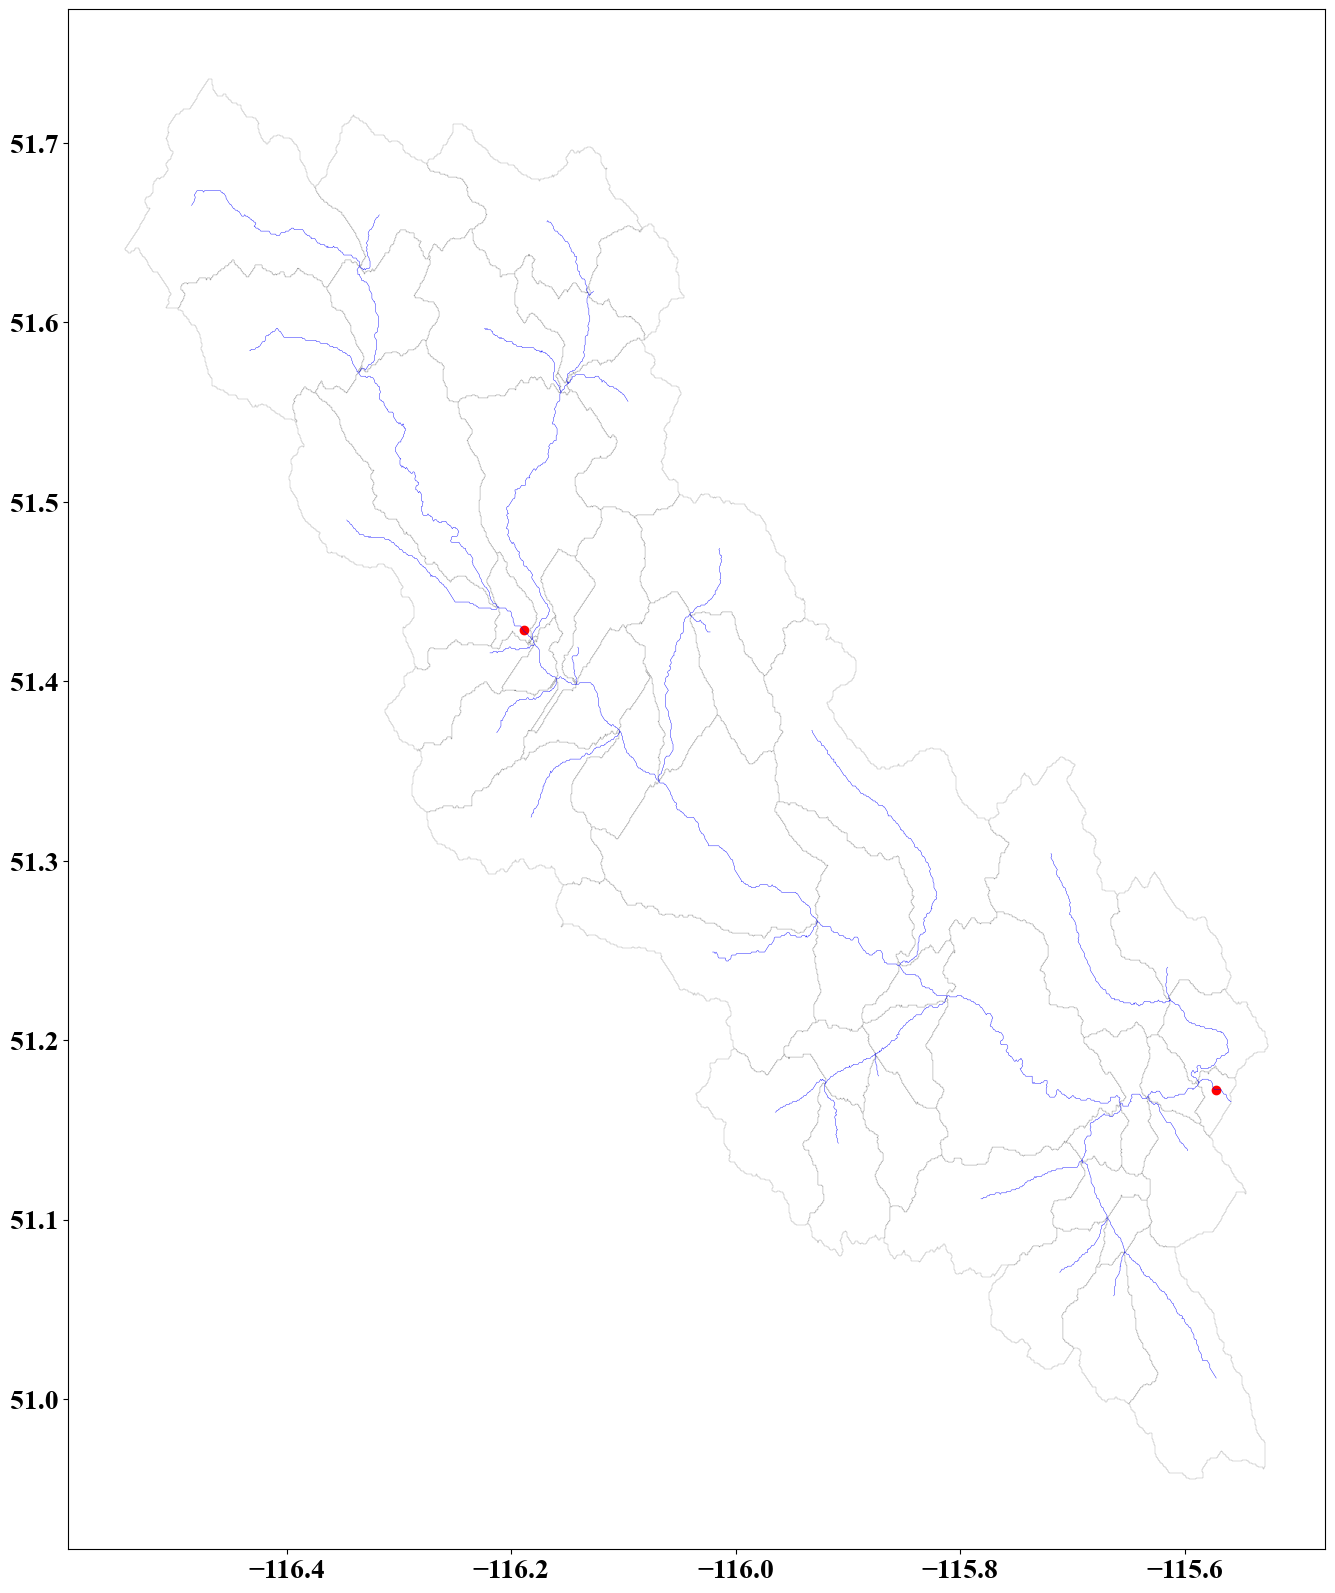

In [27]:
m = len(station)
fig,ax = plt.subplots(figsize=(20, 20))
catchment.plot(color='white', edgecolor='k', label = 'Catchment Boundary', linewidth=0.1, ax = ax)
river.plot(color='blue', label = 'River Network', linewidth=0.3, ax=ax)
wsc.plot(color='red', label = 'Water Survey Stations',ax=ax)

##### Add label for WSC stations

In [28]:
for i in range(m):
    plt.text(wsc['Longitude'][i]-0.05, wsc['Latitude'][i]+0.01, wsc['Station'][i], fontsize=14)

# set lables 
ax.set_title('BowBanff Basin')
ax.set_xlabel('Longitude [degree east]')
ax.set_ylabel('Latitude [degree north]')

ax.grid(True)
ax.legend(fontsize=14)

# save image 
plt.savefig(outdir+"WSC_Gauge.png", format='png', dpi=600)

plt.show()
plt.close()

### Display daily hydrograghs

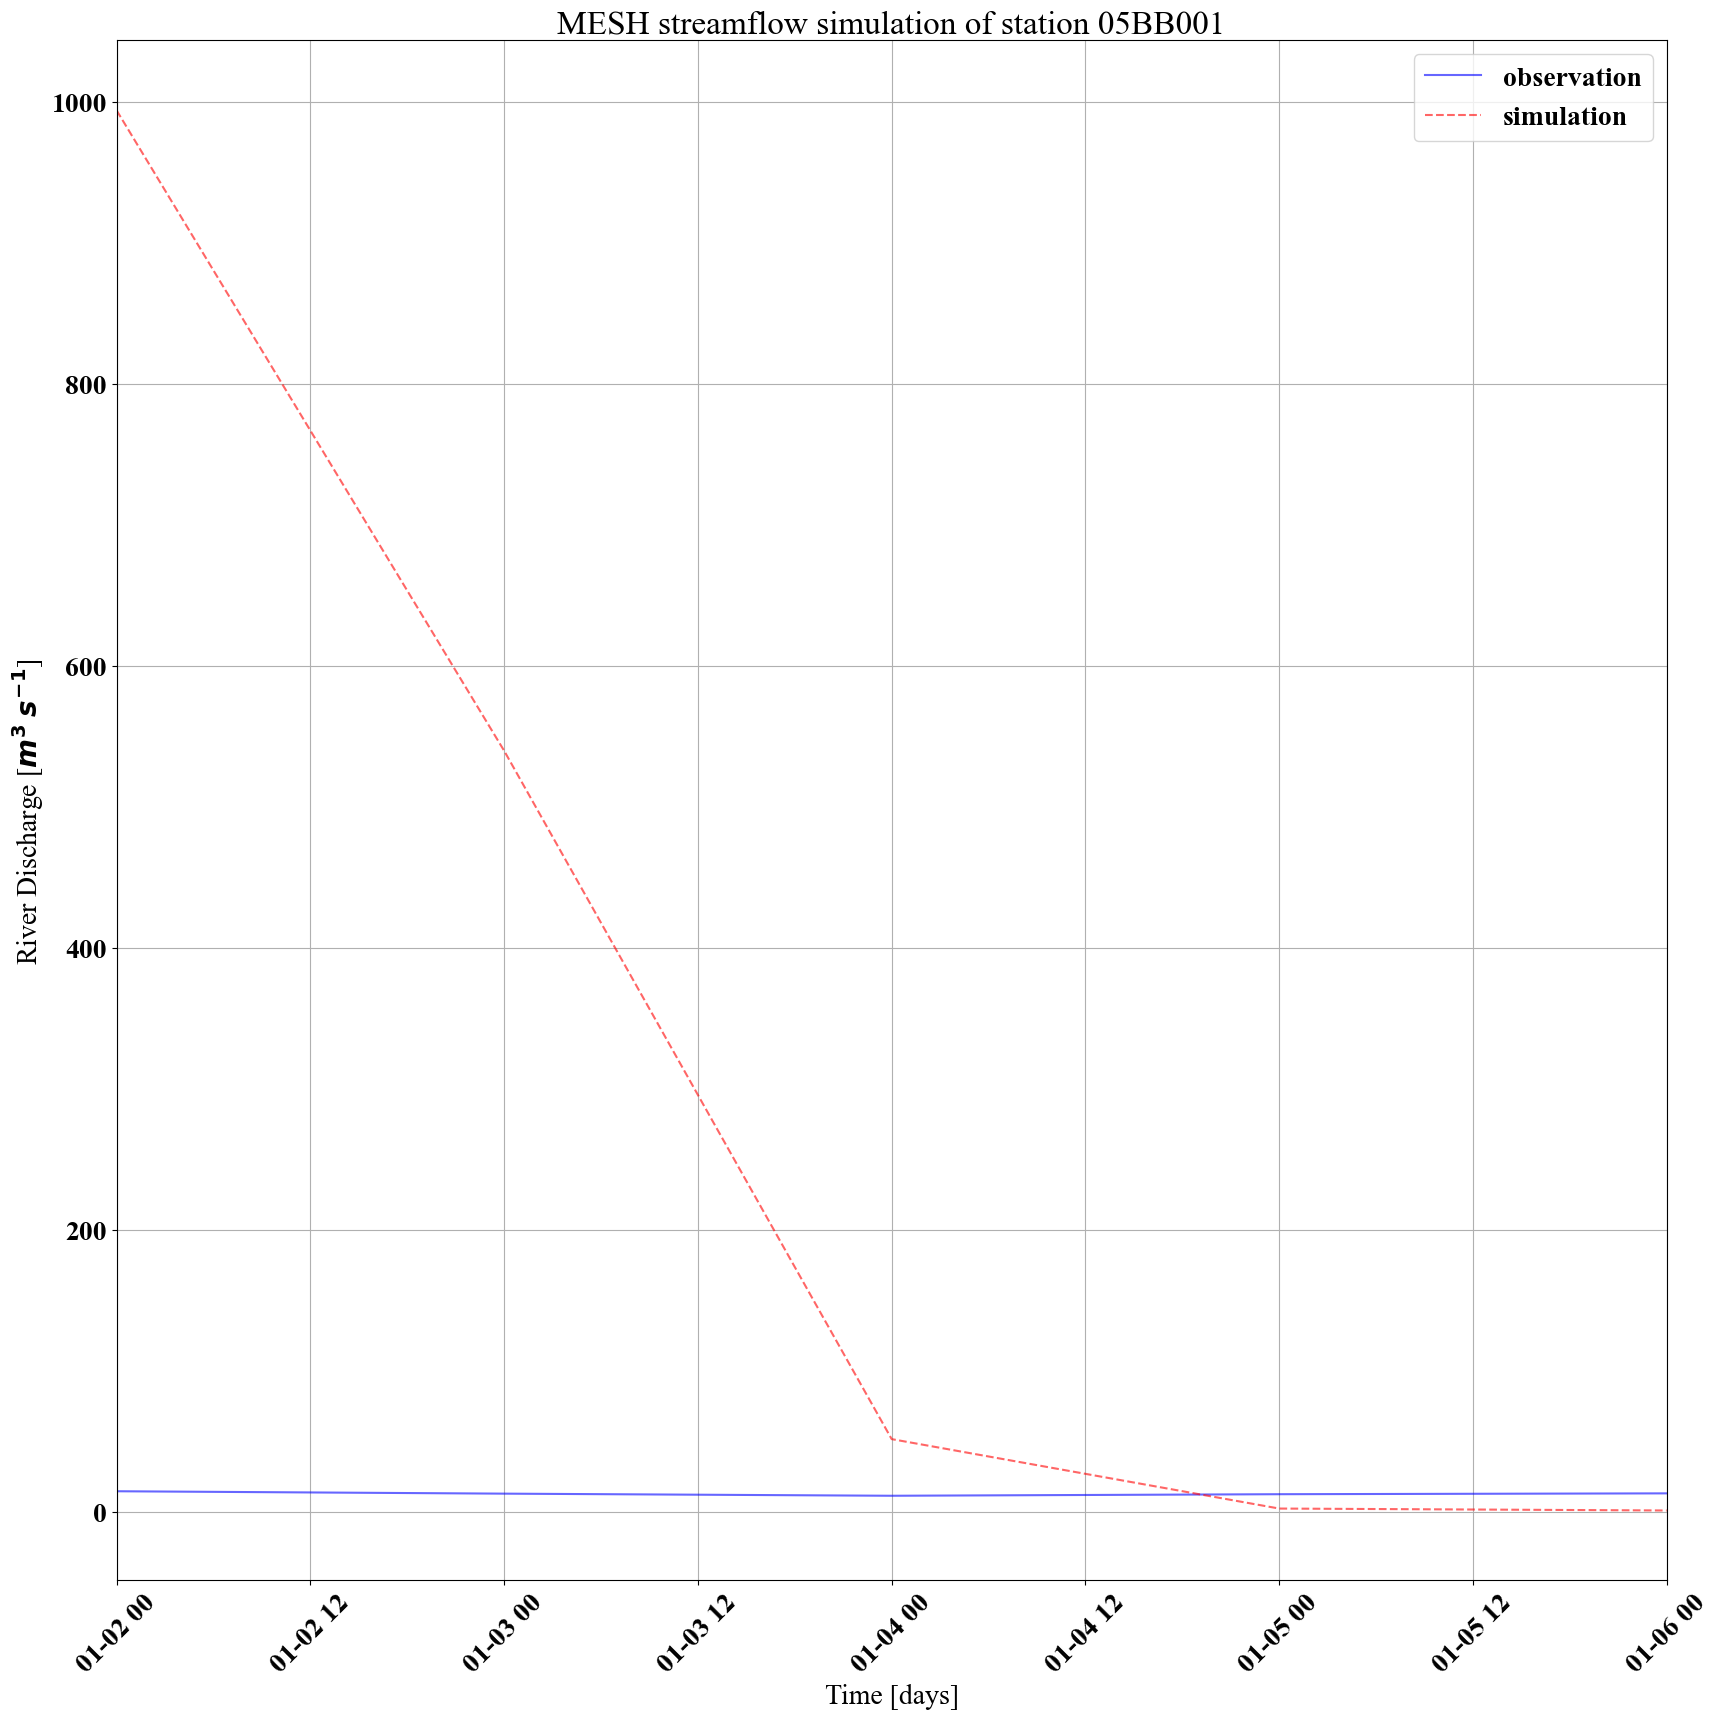

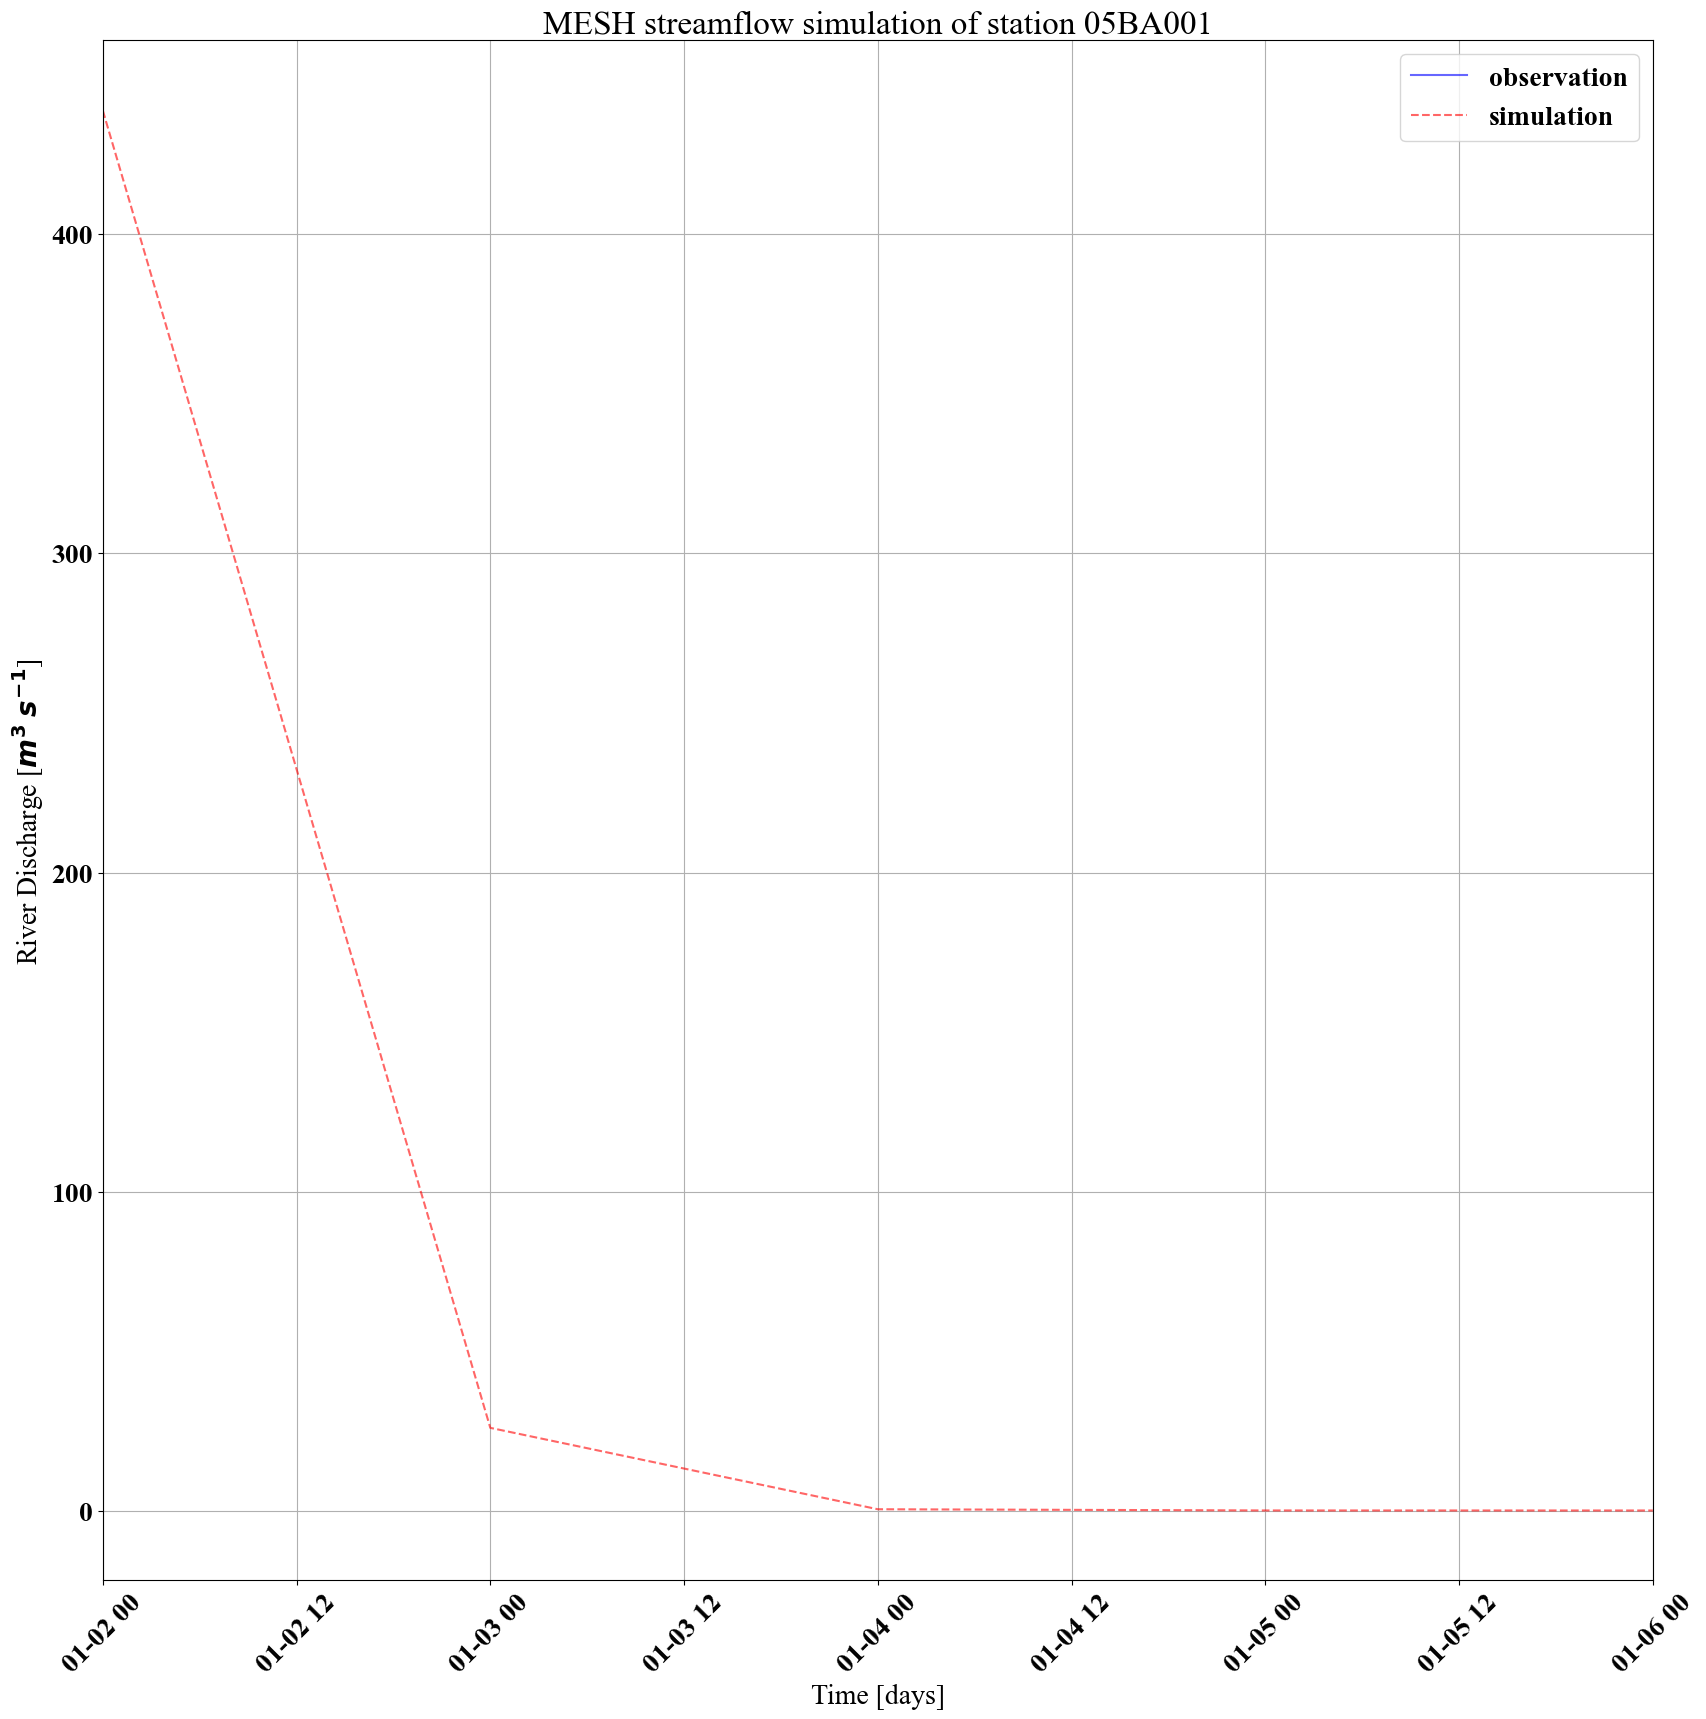

In [29]:
for k in range(m):
    fig,axs = plt.subplots(figsize=(20, 20))
    obs = 'QOMEAS%d'%(k+1)
    sim = 'QOSIM%d'%(k+1)
    axs.plot(time, stflo[obs],
                linestyle = lsty[0],
                color=cl[0], alpha=0.6, 
                label = names[0])
    axs.plot(time, stflo[sim],
                linestyle = lsty[1],
                color=cl[1], alpha=0.6,
                label = names[1])

    # setting labels 
    axs.set_title('MESH streamflow simulation of station '+station[k])
    axs.set_xlabel('Time [days]')
    axs.set_ylabel("River Discharge [$m^{3}$ $s^{-1}$]")
    # setting axis 
    plt.xticks(rotation=45)
    axs.grid(True)
    axs.legend()
    
    # setting xlim
    axs.set_xlim(time[0], time[n-1])
    
    # saving image 
    plt.savefig(outdir+station[k]+"_streamflow.png", format='png', dpi=600)    
    
    # showing and closing 
    plt.show()
    plt.close()